# Báo cáo Project môn học TIME SERIES

Nhóm: ....

Danh sách nhóm
1. 
2. 
3. 

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

## Overview and Visualize Time series

In [2]:
from datetime import datetime
dateparse = lambda dates : datetime.strptime(dates, '%Y-%m-%d')

data = pd.read_csv('daily-min-temperatures.csv', index_col=0, parse_dates=['Date'], date_parser=dateparse)
data.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [3]:
data.tail()

,Temp
Date,
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


In [4]:
data.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


Data là nhiệt độ tối thiểu hằng ngày 10 năm (1981-1990) ở Melbourne, Australia.<br>
Nhiệt độ thấp nhất trong 10 năm là 0&deg;C, cao nhất là 26.3&deg;C<br>
Các giá trị Q1, Q2, Q3 cho thấy một dạng phân phối chuẩn của nhiệt độ min<br>
Dường như năm nhuận đã được xử lý từ trước vì chỉ có đúng 3650 quan sát trong 10 năm<br>

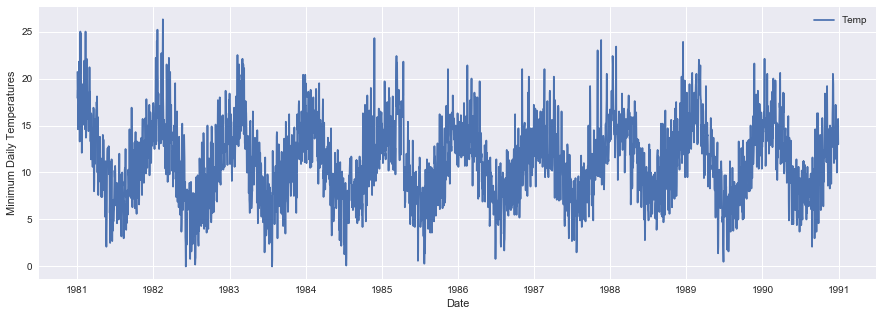

In [5]:
plt.figure(figsize=[15,5])

plt.plot(data, label='Temp')
plt.legend(loc=2)
plt.xlabel('Date')
plt.ylabel('Minimum Daily Temperatures')
plt.legend(loc='best')
plt.show()

>- Mùa Đông ở Melbourne, Australia nằm vào khoảng tháng 6 đến tháng 9 trong năm, mùa hè từ tháng 11 đến tháng 2 năm sau <br>
>- Không có các giá trị oulier trong Time series này. <br>
>- Có thể nhận thấy ngay rằng nó có season rất rõ ràng theo từng năm. Phù hợp với dữ liệu nhiệt độ ứng với thời tiết khí hậu của một khu vực theo từng năm.
>- Trend trên của TS cũng không rõ ràng, dường như không có xu hướng thay đổi nhiệt độ trên tổng thể 10 năm

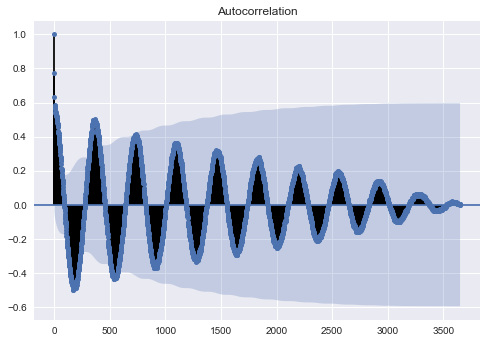

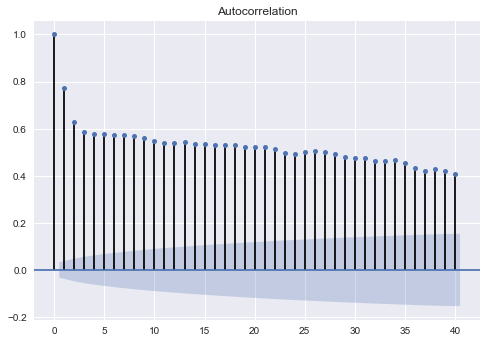

In [6]:
plot_acf(data['Temp'], fft=False, lags=len(data)-1)
plot_acf(data['Temp'], fft=False, lags=40)

plt.show()

Đồ thị ACF càng chứng minh thêm rằng đây ko phải là 1 stationary TS <br>
>- ACF giảm đều theo thời gian và dao động dạng sin nhưng tốc độ giảm là rất chậm
>- Đến lags thứ 40 ACF vẫn còn là 0.4

***
<h3>Ta sẽ xây dựng mô hình với đầy đủ Trend, Season và Error:<h3> <br>
<center> $Y_{t}=f(Trend_{t}, Seasonality_{t}, Error_{t})$ </center>

## Trend & Seasonality

Thử làm mịn Time series bằng cách sử dụng Moving Average (MA). 

MA sẽ được thử với các khoảng thời gian khác nhau, tức là 1 tháng, 3 tháng, nửa năm và 1 năm

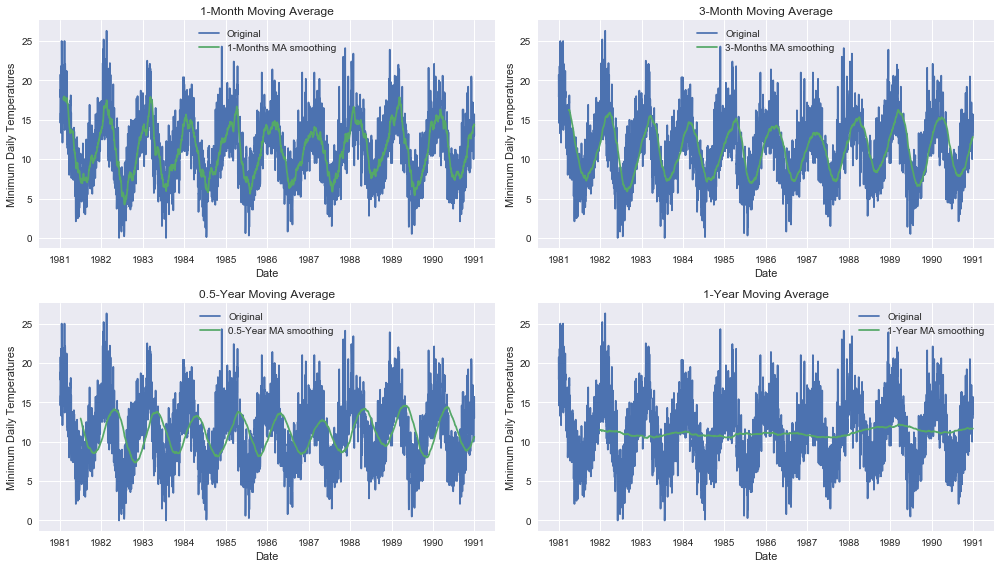

In [7]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

axes[0][0].plot(data.index, data['Temp'], label='Original')
axes[0][0].plot(data.index, data['Temp'].rolling(window=30).mean(), label='1-Months MA smoothing')
axes[0][0].set_xlabel("Date")
axes[0][0].set_ylabel("Minimum Daily Temperatures")
axes[0][0].set_title("1-Month Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(data.index, data['Temp'], label='Original')
axes[0][1].plot(data.index, data['Temp'].rolling(window=90).mean(), label='3-Months MA smoothing')
axes[0][1].set_xlabel("Date")
axes[0][1].set_ylabel("Minimum Daily Temperatures")
axes[0][1].set_title("3-Month Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(data.index, data['Temp'], label='Original')
axes[1][0].plot(data.index, data['Temp'].rolling(window=182).mean(), label='0.5-Year MA smoothing')
axes[1][0].set_xlabel("Date")
axes[1][0].set_ylabel("Minimum Daily Temperatures")
axes[1][0].set_title("0.5-Year Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(data.index, data['Temp'], label='Original')
axes[1][1].plot(data.index, data['Temp'].rolling(window=365).mean(), label='1-Year MA smoothing')
axes[1][1].set_xlabel("Date")
axes[1][1].set_ylabel("Minimum Daily Temperatures")
axes[1][1].set_title("1-Year Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

Kết quả cho thấy MA với dữ liệu 365 ngày (1 năm) loại bỏ được là bộ phần dao động sin, cho thấy được Trend của TS

**Quan sát cụ thể và chi tiết hơn đối với 365-day (1-year) moving average:**

In [8]:
MA_mean = data['Temp'].rolling(window=365).mean()
MA_std = data['Temp'].rolling(window=365).std()

mean_arr = np.full(len(data['Temp']), data['Temp'].mean())
Mean_all_obs = pd.DataFrame(data=mean_arr, index=data.index)
mean_arr[0]

11.177753424657539

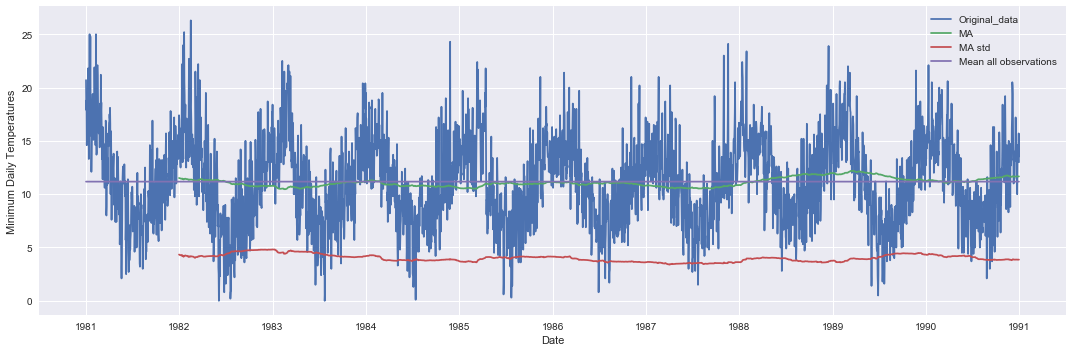

In [9]:
plt.figure(figsize=[15,5])

plt.plot(data['Temp'], label='Original_data')
plt.plot(MA_mean, label='MA')
plt.plot(MA_std, label='MA std')
plt.plot(Mean_all_obs, label='Mean all observations')

plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('Minimum Daily Temperatures')

plt.tight_layout()
plt.show()

Dựa trên plot có thể thấy là không có trend trên TS này<br>
Đường MA dao dộng nhẹ xung quanh giá trị trung bình toàn dữ liệu.<br>
Độ lệch chuẩn giá trị nhỏ (4) và cũng không biến động quá nhiều.

## Errors

Để mô hình Time series nhiệt độ nhỏ nhất trong ngày ở Melbourne, Australia, Ta sẽ sử dụng mô hình cộng tính như sau: <br>
<center> $Y_{t} = Trend_{t} + Seasonality_{t} + Error_{t}$ </center>

Mô hình nhân tính không được sử dụng vì TS chứa giá trị âm và 0, muốn sử dụng thì cần transform data.

Sử dụng Diffirencing để Loại bỏ Trend và Seasonality

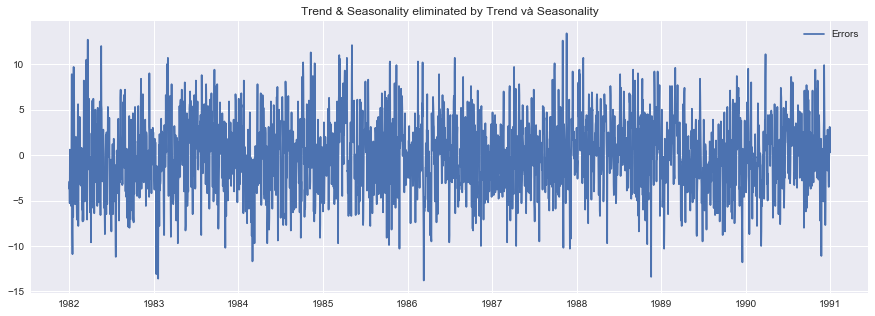

In [10]:
X = data['Temp']
differenced = X.diff(periods=365)
differenced = differenced[365:] #xoá 365 giá trị NaN đầu tiên do diff() tạo ra

plt.figure(figsize=[15,5])
plt.grid(True)
plt.plot(differenced, label='Errors')
plt.legend(loc='best')
plt.title('Trend & Seasonality eliminated by Trend và Seasonality')
plt.show()

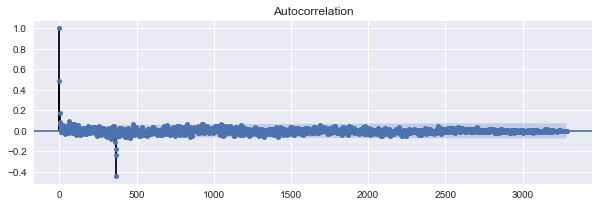

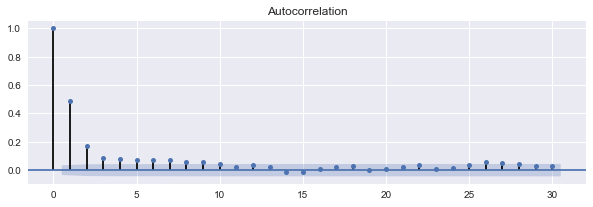

In [11]:
#ACF với toàn bộ lags
fig1 = plot_acf(differenced, fft=False, lags=len(differenced)-1)
fig1.set_figwidth(10)
fig1.set_figheight(3)

#ACF với toàn bộ lags cho 30 lags đầu tiên
fig2 = plot_acf(differenced, fft=False, lags=30)
fig2.set_figwidth(10)
fig2.set_figheight(3)
plt.show()


Ta thấy ACF của phần errors còn lại: giảm rất nhanh từ lag thứ 0 đến lag thứ 2, từ lag thứ 3 trở đi giá trị còn rất nhỏ $(-0.1 < autocorrelation < 0.1)$ ở tất cả các lag. Chỉ có khoảng 3 vị trí là lags là ngoại lệ nhưng ACF cũng chỉ từ -0.2 đến -0.4<br>

>- Errors này chính là stationary

---
Thử thực hiện bằng thư viện seasonal_decompose 

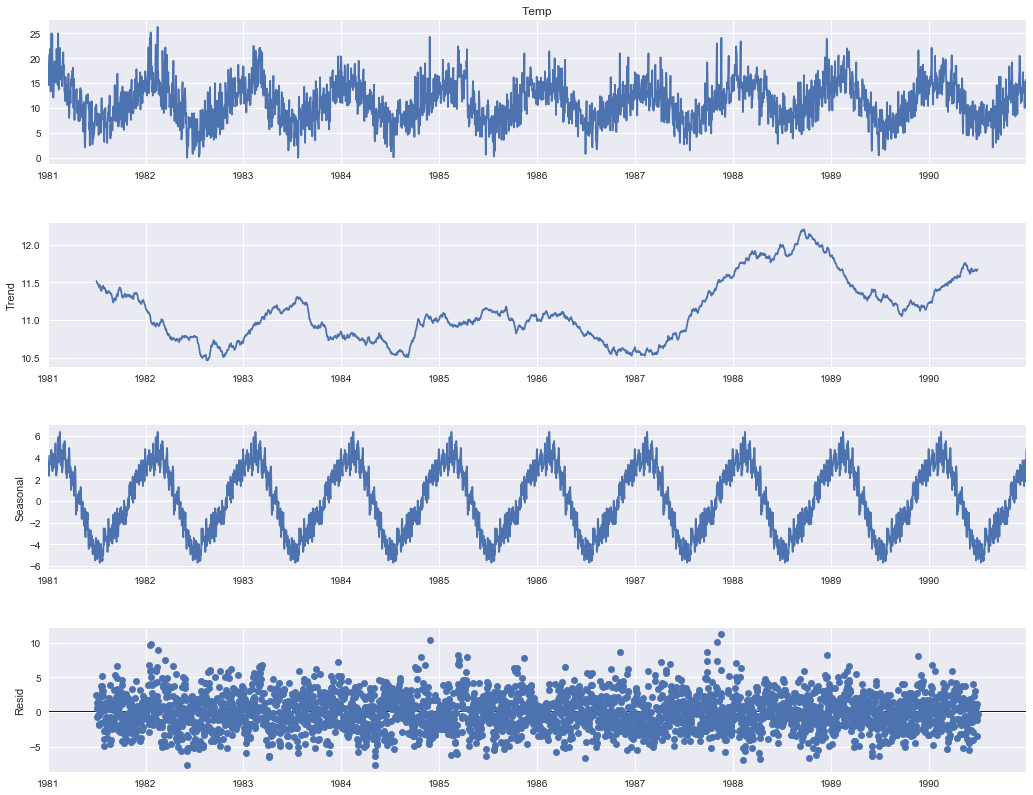

In [12]:
decomp_add = sm.tsa.seasonal_decompose(data['Temp'], model="additive", period=365)

fig = decomp_add.plot()
fig.set_figwidth(15)
fig.set_figheight(12)
plt.show()

Dựa vào plot ta có nhận xét:
>- Trend: gần như là đường ngang với dao động nhiệt độ từ 10.5&deg;C đế 12.2&deg;C nhưng đa số giá trị đi gần 11&deg;C
>- Seasonality: rất rõ ràng và thống nhất mùa theo từng *năm*
>- Trong mô hình Additive, Trend và Seasonal được trừ lần lượt ra khỏi mô hình để thu được thành phần Error nhiễu ngẫu nhiên. Error trong trường hợp hoàn hảo sẽ là white noise và phân bố của nó cũng cho thấy sự ngẫu nhiên (không có 1 pattern nào rõ ràng)

In [13]:
decomp_add.resid[181:3650-181]

Date
1981-07-01         NaN
1981-07-02    2.528490
1981-07-03   -0.676707
1981-07-04    0.552060
1981-07-05    1.321162
                ...   
1990-06-29   -1.161303
1990-06-30    1.140675
1990-07-01   -0.629401
1990-07-02   -0.323839
1990-07-03         NaN
Name: resid, Length: 3288, dtype: float64

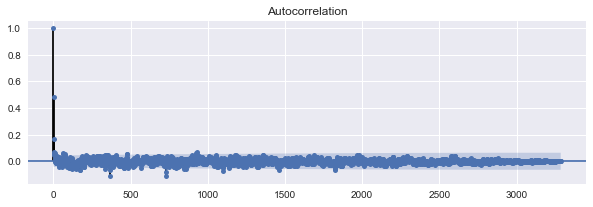

In [14]:
errors = decomp_add.resid[182:3650-182] #seasonal_decompose thực phép MA smoothing trên 2 phía
fig = plot_acf(errors, fft=False, lags = len(errors)-1)
fig.set_figwidth(10)
fig.set_figheight(3)
plt.show()

Biểu đồ ACF của phần resisduals/ errors là tương tự, iảm rất nhanh từ lag thứ 0 đến lag thứ 2, từ lag thứ 3 trở đi giá trị còn rất nhỏ $(−0.1< autocorrelation <0.1)$ ở tất cả các lag. Ta thấy rõ sự uncorrelation rõ ràng
>- Errors là stationary

---

# Model

## Phân chia tập training-test:
Vì số lượng qua sát là rất là tương đối lớn, đặc biệt và đối với dữ liệu thời tiết
Ta sẽ tiến hàn dự đoán nhiệt độ trong 1 tháng, 1 quý, nửa năm và 1 năm 

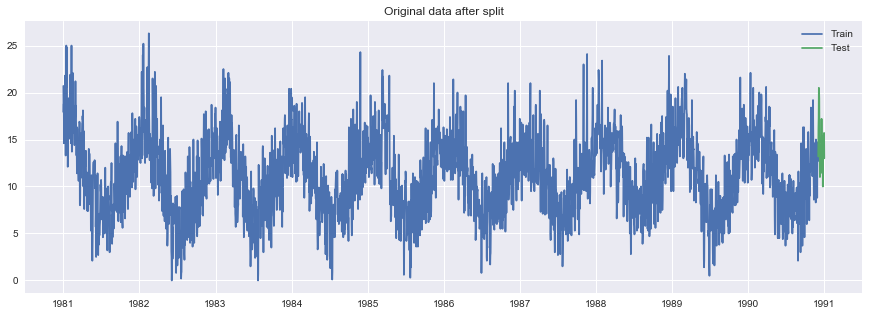

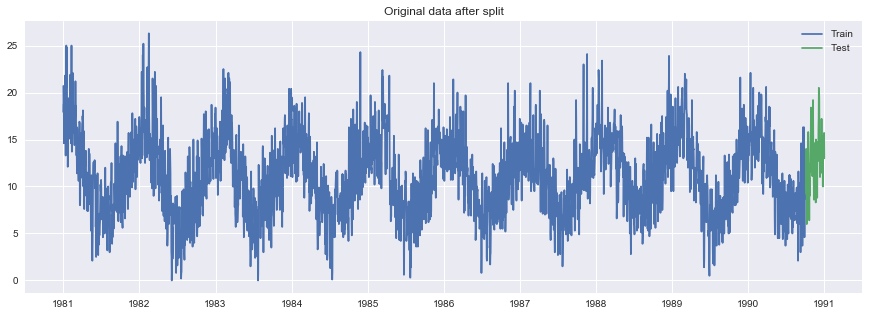

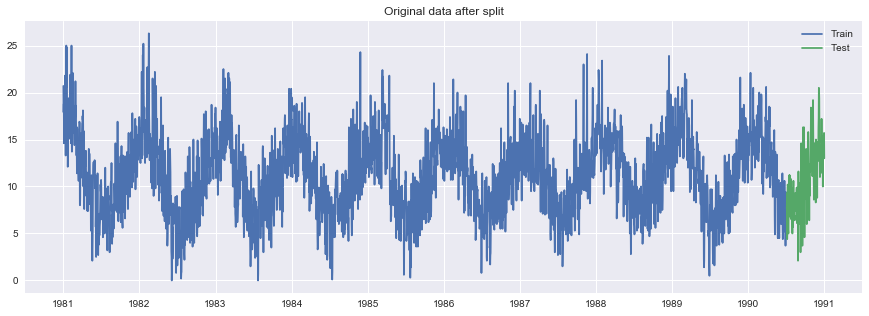

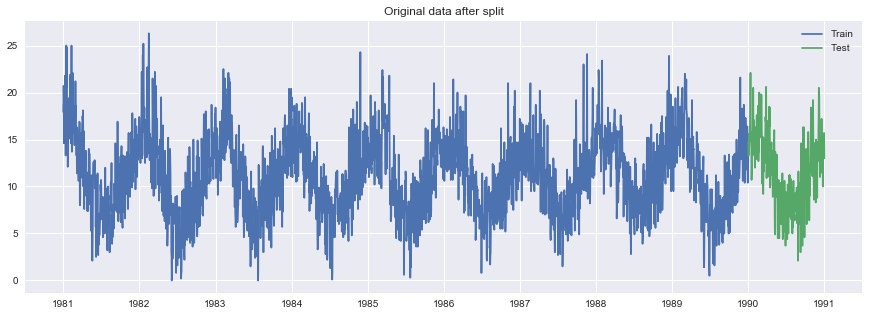

In [15]:
test_size_list = [30, 90, 182, 365]

for test_size in test_size_list:
    train = data[0:len(data)-test_size] 
    test= data[len(data)-test_size:]


    plt.figure(figsize=[15,5])
    plt.grid(True)

    plt.plot(train.index, train.Temp, label = 'Train')
    plt.plot(test.index, test.Temp,  label = 'Test')
    plt.legend(loc = 'best')
    plt.title('Original data after split')
    plt.show()

## 1. Holt-Winters’ additive method

![title](img/HW-component.png)

>- m là period - thời gian cho 1 seanson
>- k = roundown(h-1 mod m) + 1

* PT $ l_{t} $ - mức độ ước lượng tại $t$ cho thấy:
    * thành phần $(y_{t}−s_{t−m}) $; $y_{t}$ được điều chỉnh trừ đi mùa chứ không như các mô hình ES khác. Do đó nó khả năng làm việc tốt với các Time Series có component Season 
    
* PT $ b_{t} $ - Local Trend tại $t$ hoàn toàn lấy từ mô hình thống kê Holt
* PT $ s_{t} $ - Seanson tại $t$ cho thấy liên hệ giữa chỉ số mùa hiện tại $t$ và mùa trước đó $t-m$ 


Để có được mô hình ta cần ước lượng các hệ số: $\alpha, \beta^*, \gamma$ <br>
Trong đó:
>- $\alpha, \beta^* \in [0;1]$ 
>- $\gamma \in [0;1-\alpha]$ 


### 1.1 Thực hiện chi tiết với dự đoán cho 1 năm (365 ngày)
#### Build model

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

test_size = 365
train = data[0:len(data)-test_size] 
test= data[len(data)-test_size:]
    
HW_pred365 = ExponentialSmoothing(np.asarray(train['Temp']), trend='additive', 
                             damped=False, seasonal='additive',
                             seasonal_periods = 365).fit()

print('### Holt-Winters Additive ###')
print('Ước lượng các hệ số')
alpha = HW_pred365.params['smoothing_level']
beta = HW_pred365.params['smoothing_slope']
gamma = HW_pred365.params['smoothing_seasonal']

print(f'Smoothing Level:    Alpha = {alpha:.4f}')
print(f'Smoothing Slope:    Beta  = {beta:.4f}')
print(f'Smoothing Seasonal: Gamma = {gamma:.4f}')

### Holt-Winters Additive ###
Ước lượng các hệ số
Smoothing Level:    Alpha = 0.3957
Smoothing Slope:    Beta  = 0.0000
Smoothing Seasonal: Gamma = 0.0000


#### Forecast
Kết quả dự đoán như sau:

In [17]:
y_HW_pred365 =  HW_pred365.forecast(steps = test_size)
df_HW_pred365 = pd.DataFrame({'Y_hat':y_HW_pred365,'Y':test['Temp']})
print(df_HW_pred365)

                Y_hat     Y
Date                       
1990-01-01  14.186444  14.8
1990-01-02  13.824937  13.3
1990-01-03  12.872334  15.6
1990-01-04  12.294521  14.5
1990-01-05  12.142520  14.3
...               ...   ...
1990-12-27  10.355783  14.0
1990-12-28  10.137660  13.6
1990-12-29  11.267481  13.5
1990-12-30  13.599556  15.7
1990-12-31  14.396895  13.0

[365 rows x 2 columns]


Plot kết quả dự đoán:

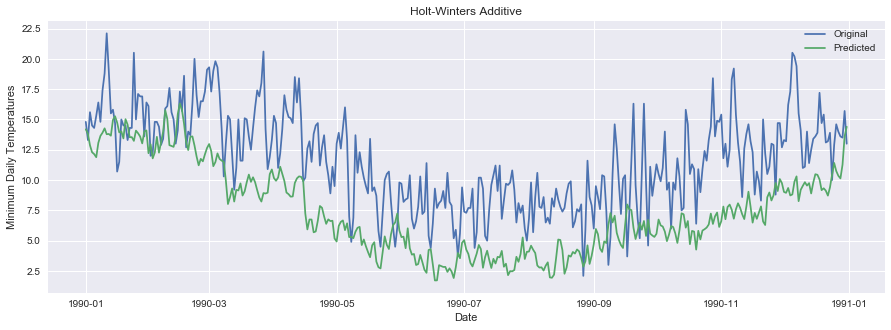

In [18]:
plt.figure(figsize=[15,5])
plt.grid(True)
plt.plot(df_HW_pred365.Y, label='Original')
plt.plot(df_HW_pred365.Y_hat, label='Predicted')

plt.legend(loc='best')
plt.title('Holt-Winters Additive')
plt.ylabel('Minimum Daily Temperatures')
plt.xlabel('Date')
plt.show()

Mô hình Holt-Winter có thể mô hình và forecast đối với Time series có có cả trend và seasonality và việc trực quan hoá dữ liệu ở trên cho thấy điều này. 

Tuy nhiên đối với thời gian dự báo quá dài có vẻ như nó có sai số khá lớn

### 1.2 Thực hiện chi tiết với dự đoán cho 1 tháng (30 ngày)

#### Build model

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

test_size = 30
train = data[0:len(data)-test_size] 
test= data[len(data)-test_size:]
    
HW_pred30 = ExponentialSmoothing(np.asarray(train['Temp']), trend='additive', 
                             damped=False, seasonal='additive',
                             seasonal_periods = 365).fit()

print('### Holt-Winters Additive ###')
print('Ước lượng các hệ số')
alpha = HW_pred30.params['smoothing_level']
beta = HW_pred30.params['smoothing_slope']
gamma = HW_pred30.params['smoothing_seasonal']

print(f'Smoothing Level:    Alpha = {alpha:.4f}')
print(f'Smoothing Slope:    Beta  = {beta:.4f}')
print(f'Smoothing Seasonal: Gamma = {gamma:.4f}')

### Holt-Winters Additive ###
Ước lượng các hệ số
Smoothing Level:    Alpha = 0.3948
Smoothing Slope:    Beta  = 0.0001
Smoothing Seasonal: Gamma = 0.0000


#### Forecast

Kết quả dự đoán như sau:

In [20]:
y_HW_pred30 =  HW_pred30.forecast(steps = test_size)
df_HW_pred30 = pd.DataFrame({'Y_hat':y_HW_pred30,'Y':test['Temp']})
print(df_HW_pred30)

                Y_hat     Y
Date                       
1990-12-02  12.850901  13.2
1990-12-03  13.368552  16.2
1990-12-04  12.703027  17.3
1990-12-05  12.842200  20.5
1990-12-06  13.785220  20.2
1990-12-07  14.329348  19.4
1990-12-08  12.304967  15.5
1990-12-09  13.143186  14.1
1990-12-10  13.862507  11.0
1990-12-11  14.191721  11.1
1990-12-12  13.751773  14.0
1990-12-13  13.418995  11.4
1990-12-14  12.818572  12.5
1990-12-15  13.714744  13.4
1990-12-16  14.632929  13.6
1990-12-17  14.721492  13.9
1990-12-18  14.311319  17.2
1990-12-19  13.434891  14.7
1990-12-20  13.216138  15.4
1990-12-21  13.207606  13.1
1990-12-22  13.054615  13.2
1990-12-23  13.379435  13.9
1990-12-24  14.561165  10.0
1990-12-25  15.534871  12.9
1990-12-26  15.098008  14.6
1990-12-27  14.655495  14.0
1990-12-28  14.447105  13.6
1990-12-29  15.504741  13.5
1990-12-30  17.620663  15.7
1990-12-31  18.611674  13.0


Plot kết quả dự đoán:

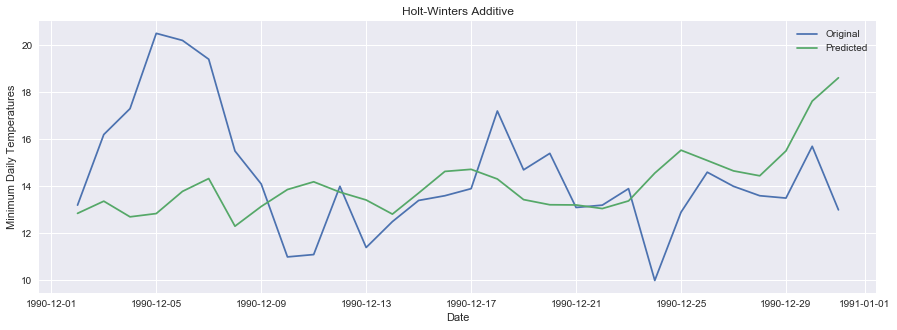

In [21]:
plt.figure(figsize=[15,5])
plt.grid(True)
plt.plot(df_HW_pred30.Y, label='Original')
plt.plot(df_HW_pred30.Y_hat, label='Predicted')

plt.legend(loc='best')
plt.title('Holt-Winters Additive')
plt.ylabel('Minimum Daily Temperatures')
plt.xlabel('Date')
plt.show()

Mô hình Holt-Winter dự báo tốt với số lượng dự báo ngắn hơn

## 2. ARIMA method


ARIMA: Auto Regressive Integrated Moving Average<br>
Bao gồm 3 thành phần:
    1. Auto Regressive: Tự hồi quy, dựa trên các giá trị quá khứ (các lags). Mô hình regression làm việc tốt khi sự uncorrelated và independent giữa các giá trị dự đoán vơi nhau (Stationary)
    2. Integrated: Sai phân, sử dụng differencing để tạo ra stationary
    3. Moving Average: Thành phần error trong mô hình 


ARIMA có thể mô hình các Non-stationary Time series

p: số lags quá khứ để hồi quy cho giá trị hiện tại. Được lựa chọn dựa trên PACF<br>
d: số bậc sai phân<br>
q: số lag của errors cần đưa vào mô hình<br>

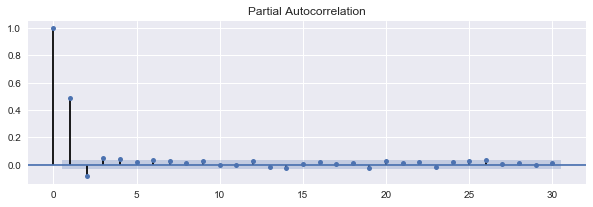

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf

fig = plot_pacf(differenced, lags=30)
fig.set_figwidth(10)
fig.set_figheight(3)


plt.show()

Lựa chọn p=3 lags để hồi quy trong mô hình AR

Bậc của I, d=0 do đã thực hiện phép sai phân và có được statinary từ trước đó

### 2.1 Thực hiện chi tiết với dự đoán cho 1 tháng (30 ngày)
#### Build model

In [23]:
from statsmodels.tsa.arima.model import ARIMA

differenced = data.diff(365)
differenced = differenced[365:]
n1 = len(data)
n2 = len(differenced)

###################
test_size = 30
train_m30 = differenced[0:n2-test_size]
test_m30 = differenced[n2-test_size:]
### history data
values_m30 = train_m30.values
history_m30 = [values_m30[i] for i in range(len(values_m30))]
### predicted data
### model and predictions:
m30 = ARIMA(history_m30, order=(3, 0, 1))
m30_fit = m30.fit()
predictions_m30 = m30_fit.forecast(30)

#### Forecast

Kết quả dự đoán như sau:

In [24]:
previous_m30 = data.iloc[len(data)-test_size-365 : len(data)-365]["Temp"].tolist()
res_m30 = []
err_m30 = []
for i in range(len(previous_m30)):
    res_m30.append(previous_m30[i] + predictions_m30[i])
    err_m30.append(previous_m30[i] + predictions_m30[i] - data.iloc[-30+i]["Temp"])

In [25]:
df_ARIMA_pred30 = pd.DataFrame({'Y':data['Temp'][-test_size:],'Y_hat':res_m30})
print(df_ARIMA_pred30)

               Y      Y_hat
Date                       
1990-12-02  13.2  16.941824
1990-12-03  16.2  12.895208
1990-12-04  17.3  12.598367
1990-12-05  20.5   9.940028
1990-12-06  20.2  13.506940
1990-12-07  19.4  15.485223
1990-12-08  15.5  16.057760
1990-12-09  14.1  13.719813
1990-12-10  11.0  18.372499
1990-12-11  11.1  15.917716
1990-12-12  14.0  14.556798
1990-12-13  11.4  12.390632
1990-12-14  12.5  10.219910
1990-12-15  13.4  12.045231
1990-12-16  13.6  12.467125
1990-12-17  13.9  11.986056
1990-12-18  17.2  17.202426
1990-12-19  14.7  16.316581
1990-12-20  15.4  12.528822
1990-12-21  13.1  12.239406
1990-12-22  13.2  11.748559
1990-12-23  13.9  11.956474
1990-12-24  10.0  12.663318
1990-12-25  12.9  16.369236
1990-12-26  14.6  15.974353
1990-12-27  14.0  13.278778
1990-12-28  13.6  11.682605
1990-12-29  13.5  10.385914
1990-12-30  15.7  14.388775
1990-12-31  13.0  12.691249


Plot kết quả dự đoán:

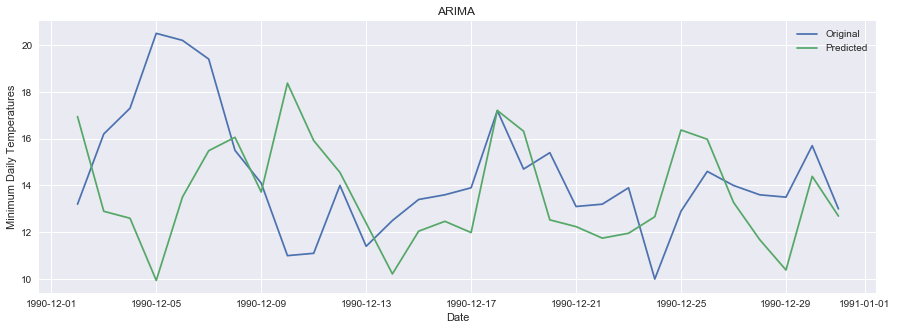

In [26]:
plt.figure(figsize=[15,5])
plt.plot(df_ARIMA_pred30.Y, label='Original')
plt.plot(df_ARIMA_pred30.Y_hat, label='Predicted')

plt.legend(loc='best')
plt.title('ARIMA ')
plt.ylabel('Minimum Daily Temperatures')
plt.xlabel('Date')
plt.show()

Mô hình ARIMA dự báo khá tốt với số lượng dự báo ngắn

### 2.2 Thực hiện chi tiết với dự đoán cho 1 năm (365 ngày)
#### Build model

In [27]:
from statsmodels.tsa.arima.model import ARIMA

test_size = 365
train_m365 = differenced[0:n2-test_size]
test_m365 = differenced[n2-test_size:]
### history data
values_m365 = train_m365.values
history_m365 = [values_m365[i] for i in range(len(values_m365))]
### predicted data
### model and predictions:
m365 = ARIMA(history_m365, order=(3, 0, 1))
m365_fit = m365.fit()
predictions_m365 = m365_fit.forecast(365)

#### Forecast

Kết quả dự đoán như sau:

In [28]:
previous_m365 = data.iloc[len(data)-test_size - 365:len(data)-365]["Temp"].tolist()
res_m365 = []
err_m365 = []
for i in range(len(previous_m365)):
    res_m365.append(previous_m365[i] + predictions_m365[i])
    err_m365.append(previous_m365[i] + predictions_m365[i] - data.iloc[-test_size+i]["Temp"])

In [29]:
df_ARIMA_pred365 = pd.DataFrame({'Y':data['Temp'][-test_size:],'Y_hat':res_m365})
print(df_ARIMA_pred365)

               Y      Y_hat
Date                       
1990-01-01  14.8  13.392074
1990-01-02  13.3  16.885119
1990-01-03  15.6  18.129952
1990-01-04  14.5  16.472856
1990-01-05  14.3  11.199439
...          ...        ...
1990-12-27  14.0  13.262975
1990-12-28  13.6  11.662975
1990-12-29  13.5  10.362975
1990-12-30  15.7  14.362975
1990-12-31  13.0  12.662975

[365 rows x 2 columns]


Plot kết quả dự đoán:

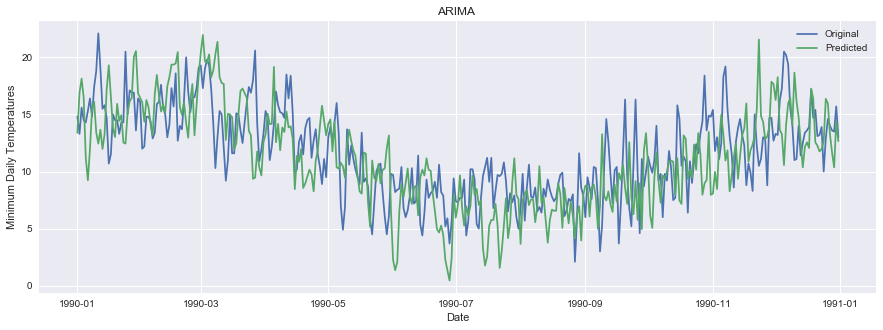

In [30]:
plt.figure(figsize=[15,5])
plt.plot(df_ARIMA_pred365.Y, label='Original')
plt.plot(df_ARIMA_pred365.Y_hat, label='Predicted')

plt.legend(loc='best')
plt.title('ARIMA ')
plt.ylabel('Minimum Daily Temperatures')
plt.xlabel('Date')
plt.show()

Mô hình ARIMA có thể mô hình và forecast đối với Time series có có cả trend và seasonality

Với thời gian dự báo quá dài ARIMA vẫn dự báo tốt hơn so với Hol-Winter

---

### Tiếp theo ta sẽ đánh giá kết quả dự đoán của mô hình

Định nghĩa 3 metrics đánh giá:
>- Mean squared error:
#### <center>$ MSE = \frac{1}{N} \sum \limits _{i=1} ^{N} {( Y_{i} - \hat{Y}_{i} )}^2 $<center>
    
>- Mean absolute error:
#### <center>$ MAE = \frac{1}{N} \sum \limits _{i=1} ^{N} | Y_{i} - \hat{Y}_{i} | $<center>
    
>- Mean absolute percentage error:
#### <center>$ MSE = \frac{100}{N} \sum \limits _{i=1} ^{N} \frac{Y_{i} - \hat{Y}_{i}}{Y_{i}} $<center>

In [31]:
def MSE(Y_true,Y_pred): 
    Y_true, Y_pred = np.array(Y_true), np.array(Y_pred)
    return np.mean(np.square(Y_pred - Y_true))

def MAE(Y_true,Y_pred): 
    Y_true, Y_pred = np.array(Y_true), np.array(Y_pred)
    return np.mean(np.abs(Y_pred - Y_true))


def MAPE(Y_true, Y_pred): 
    Y_true, Y_pred = np.array(Y_true), np.array(Y_pred)
    return np.mean(np.abs(Y_pred - Y_true)/Y_true) * 100

In [32]:
rmse_HW_30 = np.sqrt(MAPE(df_HW_pred30.Y, df_HW_pred30.Y_hat))
mae_HW_30 = MAE(df_HW_pred30.Y, df_HW_pred30.Y_hat)
mape_HW_30 = MAPE(df_HW_pred30.Y, df_HW_pred30.Y_hat)


rmse_ARIMA_30 = np.sqrt(MAPE(df_ARIMA_pred30.Y, df_ARIMA_pred30.Y_hat))
mae_ARIMA_30 = MAE(df_ARIMA_pred30.Y, df_ARIMA_pred30.Y_hat)
mape_ARIMA_30 = MAPE(df_ARIMA_pred30.Y, df_ARIMA_pred30.Y_hat)

In [33]:
print('Kết quả cho mô hình AR forecast nhiệt độ trong 1 tháng:')
print('=================================')
print(f'Holt-Winter forecast:\nRMSE = {rmse_HW_30:.2f}, MAE = {mae_HW_30:.2f}, MAPE = {mape_HW_30:.2f}')
print('=================================')
print(f'ARIMA forecast:\nRMSE = {rmse_ARIMA_30:.2f}, MAE = {mae_ARIMA_30:.2f}, MAPE = {mape_ARIMA_30:.2f}')

Kết quả cho mô hình AR forecast nhiệt độ trong 1 tháng:
Holt-Winter forecast:
RMSE = 3.90, MAE = 2.25, MAPE = 15.23
ARIMA forecast:
RMSE = 4.23, MAE = 2.60, MAPE = 17.93


Với việc forecast cho giá trị nhiệt độ, ta thấy MAE và MAPE có thể sử dụng để diễn giải như sau:

* Nếu dự báo cho 1 tháng = 30 ngày = 30 dự báo:
    * Holt-Winter:
        * Sai số trung bình trên tất cả 30 dự báo vào khoảng 2.25&deg;C
        * Sai số trung bình chiếm khoảng 15.23% nhiệt độ thực tế 
        
    * ARIMA:
        * Sai số trung bình trên tất cả 30 dự báo vào khoảng 2.58&deg;C
        * Sai số trung bình chiếm khoảng 17.86% nhiệt độ thực tế 
>- Như vậy với 30 điểm forecast, Holt-Winter cho kết quả tốt hơn ở cả 3 Metrics

---
### So sánh hiệu quả của cả 2 Mô hình ARIMA và Holt-Winter với các khoảng forecast nhiệt độ khác nhau:
>- Trong 1 tháng, 1 quý, nửa năm và 1 năm 

In [34]:
test_size_list = [30, 90, 182, 365]

########################################
print(f'###  Kết quả cho mô hình Holt-Winter  ###')
print('=================================')
for test_size in test_size_list:
    train = data[0:len(data)-test_size] 
    test = data[len(data)-test_size:]
    
    pred1 = ExponentialSmoothing(np.asarray(train['Temp']), trend='additive', damped=False, seasonal='additive',
                                  seasonal_periods = 365).fit()
    
    y_pred1 =  pred1.forecast(steps=test_size)
    df_pred1 = pd.DataFrame({'Y_hat':y_pred1,'Y':test['Temp']})
    
    rmse = np.sqrt(MAPE(df_pred1.Y, df_pred1.Y_hat))
    mae = MAE(df_pred1.Y, df_pred1.Y_hat)
    mape = MAPE(df_pred1.Y, df_pred1.Y_hat)
    print(f'Forecast {test_size:3} ngày: RMSE = {rmse:.2f}, MAE = {mae:.2f}, MAPE = {mape:.2f}')


########################################
print(f'###  Kết quả cho mô hình ARIMA  ###')
print('=================================')
n1 = len(data)
n2 = len(differenced)

for test_size in test_size_list:
    train = differenced[0:n2-test_size]
    test = differenced[n2-test_size:]
    
    ### history data
    values = train.values
    history = [values[i] for i in range(len(values))]
    ### predicted data
    ### model and predictions:
    pred2 = ARIMA(history, order=(3, 0, 1))
    pred2_fit = pred2.fit()
    predictions = pred2_fit.forecast(test_size)
    
    previous = data.iloc[len(data)-test_size-365:len(data)-365]["Temp"].tolist()
    res = []
    err = []
    for i in range(len(previous)):
        
        res.append(previous[i] + predictions[i])
        err.append(previous[i] + predictions[i] - data.iloc[-test_size+i]["Temp"])
    

    df_pred2 = pd.DataFrame({'Y':data['Temp'][-test_size:],'Y_hat':res})

    rmse = np.sqrt(MAPE(df_pred2.Y, df_pred2.Y_hat))
    mae = MAE(df_pred2.Y, df_pred2.Y_hat)
    mape = MAPE(df_pred2.Y, df_pred2.Y_hat)
    print(f'Forecast {test_size:3} ngày: RMSE = {rmse:.2f}, MAE = {mae:.2f}, MAPE = {mape:.2f}')


###  Kết quả cho mô hình Holt-Winter  ###
Forecast  30 ngày: RMSE = 3.90, MAE = 2.25, MAPE = 15.23
Forecast  90 ngày: RMSE = 4.18, MAE = 2.21, MAPE = 17.46
Forecast 182 ngày: RMSE = 5.08, MAE = 2.55, MAPE = 25.83
Forecast 365 ngày: RMSE = 6.21, MAE = 4.36, MAPE = 38.60
###  Kết quả cho mô hình ARIMA  ###
Forecast  30 ngày: RMSE = 4.23, MAE = 2.60, MAPE = 17.93
Forecast  90 ngày: RMSE = 4.78, MAE = 2.86, MAPE = 22.80
Forecast 182 ngày: RMSE = 5.46, MAE = 2.90, MAPE = 29.85
Forecast 365 ngày: RMSE = 5.31, MAE = 2.87, MAPE = 28.24


Ta có nhận xét như sau: 
* Với dữ liệu Time Series khá lớn: theo dõi về nhiệt độ nhỏ nhất trong thời gian khá dài - 3650 quan sát trong 10 năm.
* Cả 2 mô hình Holt-Winter và ARIMA đều cho kết quả dự đoán tương đối tốt đối với Time Series có chứa yếu tố Season
    * Hiệu năng dự đoán của Holt-Winter trong khoảng thời gian ngắn hơn (<6 tháng) là khá tốt ở mức chấp nhận được đối với 1 dự báo thời tiết và giảm dần độ tin cậy nếu yều cầu số lượng dự đoán quá nhiều. 
    * ARIMA thì ngược lại trong khoảng thời gian ngắn vẫn cho khả năng dự báo chấp nhận được nhưng độ chính xác lại thấp hơn Holt-Winter.
    * ARIMA thể hiện sự vượt trội của mình trong những tình huống dự đoán dài hơn, sai số dự đoán tương đối ổn định nếu thay đổi số lượng dự đoán
    
